# 1. Data Preparation

## 1.1 Down - load - clean - dataset



In [3]:
!gdown --id 1nxR07ebVNc5bSgfTQjeUcAoyoaNuuH6s

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nxR07ebVNc5bSgfTQjeUcAoyoaNuuH6s
To: /content/IMDB-Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 113MB/s]


In [1]:
import pandas as pd
datafile_path = 'IMDB-Dataset.csv'
df = pd.read_csv(datafile_path)
df = df.drop_duplicates()
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [2]:
!pip install contractions

In [3]:
# Cleaning
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def expand_contractions(text):
    return contractions.fix(text)

def clean_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text, 'html.parser') # Removing html tags
    text = soup.get_text()

    text = expand_contractions(text)

    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F" # emoticons
                            u"\U0001F300-\U0001F5FF" # symbols & pictographs
                            u"\U0001F680-\U0001F6FF" # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags =re.UNICODE )
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r'\.(?=\s)', '. ', text)
    text = re.sub(r'http\S+','', text)
    text = ''.join([
        word.lower() for word in text if word not in string.punctuation
    ])
    text = ' '.join([
        wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()
    ])
    return text

In [5]:
df['review'] = df['review'].apply(clean_text)

<ipython-input-4-f65dcdefeffc>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser') # Removing html tags


In [6]:
df.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive


In [7]:
!pip install -U torchtext==0.12.0

In [10]:
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer('basic_english')
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)
vocab = build_vocab_from_iterator(
    iterator=yield_tokens(sentences=df['review'], tokenizer=tokenizer),
    specials=['<unk>', '<pad>'],
)

In [11]:
len(vocab.get_itos())


200867

## 1.2 Data Analysis



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

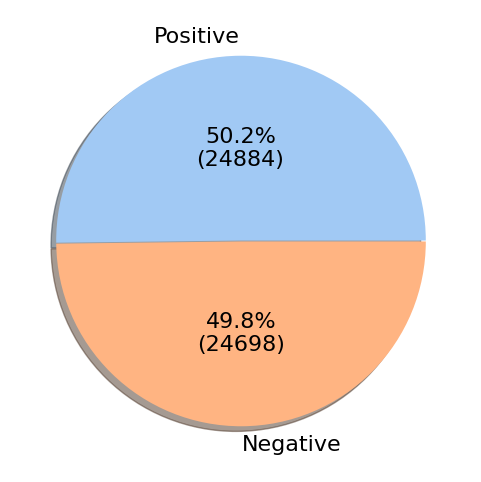

In [13]:
def func(pct, allvalues):
    absolute = int(np.round(pct/100.*np.sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment']=='positive'])
freq_neg = len(df[df['sentiment']=='negative'])

pie, ax = plt.subplots(figsize=(6,6))
plt.pie([freq_pos, freq_neg], labels=['Positive', 'Negative'], autopct=lambda pct: func(pct, [freq_pos, freq_neg]), explode=[0.0025, 0.0025], shadow=True, pctdistance=0.5, textprops={'fontsize': 16}, colors=[sns.color_palette("pastel")[0], sns.color_palette("pastel")[1]])
plt.show()

In [14]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_tmp = df.copy()
df_tmp['words_len'] = words_len
df_tmp.head()

,review,sentiment,words_len
0,one reviewer mentioned watching oz episode hoo...,positive,162
1,wonderful little production filming technique ...,positive,84
2,thought wonderful way spend time hot summer we...,positive,84
3,basically family little boy jake think zombie ...,negative,62
4,petter matteis love time money visually stunni...,positive,125


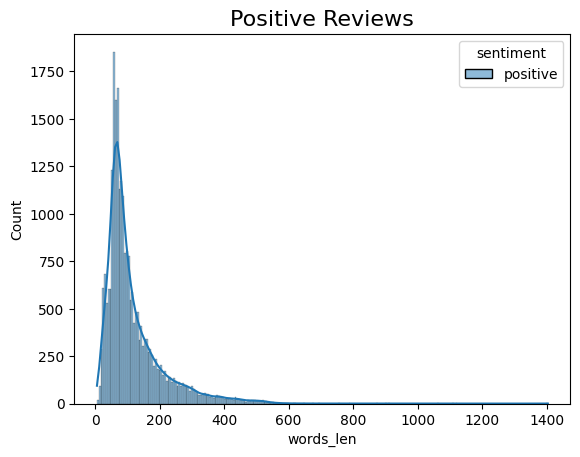

<ipython-input-15-c2c7b215c2b6>:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  hist_neg = sns.histplot(data=df_tmp[df_tmp['sentiment']=='negative'], x='words_len', hue='sentiment', kde=True, palette=[sns.color_palette("pastel")[1], 'red'], legend=True)


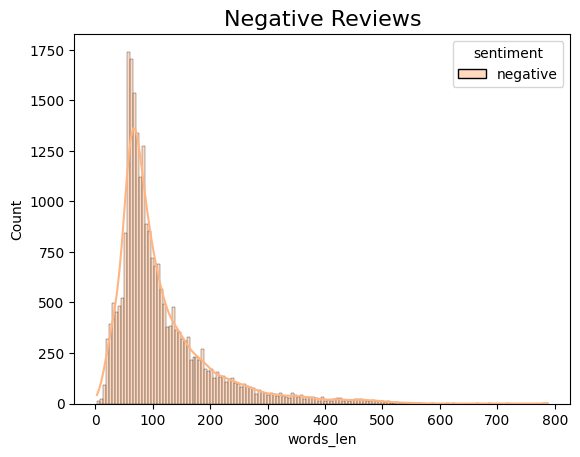

In [15]:
hist_pos = sns.histplot(data=df_tmp[df_tmp['sentiment']=='positive'], x='words_len', hue='sentiment', kde=True, color=sns.color_palette("pastel")[0], legend=True)
hist_pos.set_title('Positive Reviews', fontsize=16)
plt.show(hist_pos)
hist_neg = sns.histplot(data=df_tmp[df_tmp['sentiment']=='negative'], x='words_len', hue='sentiment', kde=True, palette=[sns.color_palette("pastel")[1], 'red'], legend=True)
hist_neg.set_title('Negative Reviews', fontsize=16)
plt.show(hist_neg)


## 1.3 Train-Test split and embedding

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [17]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter matteis love time money visually stunni...,1


In [18]:
X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train, y_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [20]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(39665, 10000)
(9917, 10000)


# 2. Training

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [22]:
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(X_train_tfidf, y_train)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)


RandomForestClassifier(random_state=42)

# 3. Evaluation

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [24]:
y_pred_dt = dt_classifier.predict(X_test_tfidf)
y_pred_rf = rf_classifier.predict(X_test_tfidf)

In [25]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_rf = confusion_matrix(y_test, y_pred_rf)

In [26]:
print('Decision Tree Classifier')
print('Confusion Matrix\n', cm_dt)
print('Accuracy Score: ', accuracy_score(y_test, y_pred_dt))
print('Precision Score: ', precision_score(y_test, y_pred_dt))
print('Recall Score: ', recall_score(y_test, y_pred_dt))
print('F1 Score: ', f1_score(y_test, y_pred_dt))

print('Random Forest Classifier')
print('Confusion Matrix\n', cm_dt)
print('Accuracy Score: ', accuracy_score(y_test, y_pred_rf))
print('Precision Score: ', precision_score(y_test, y_pred_rf))
print('Recall Score: ', recall_score(y_test, y_pred_rf))
print('F1 Score: ', f1_score(y_test, y_pred_rf))

Decision Tree Classifier
Confusion Matrix
 [[3499 1440]
 [1442 3536]]
Accuracy Score:  0.7093879197337905
Precision Score:  0.7106109324758842
Recall Score:  0.7103254319003616
F1 Score:  0.7104681535061281
Random Forest Classifier
Confusion Matrix
 [[3499 1440]
 [1442 3536]]
Accuracy Score:  0.8408792981748513
Precision Score:  0.8449675324675324
Recall Score:  0.8364805142627562
F1 Score:  0.8407026044821321
